In [1]:
from IPython.core.display import display, HTML

### Widen notebook to fit browser window
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os, glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

from configuration import dict_config_params
from sliding_windows import search_windows, slide_window, draw_boxes, find_cars
from sliding_windows import add_heat, apply_heat_threshold, draw_labeled_bboxes, get_heat_based_bboxes
from classifiers import get_training_data, fit_svm

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video_frame(frame):
    # NOTE: output should be a color image (3 channel) for processing video below    
    global dict_config_params
    global num_frames_processed  
    global svc, X_scaler
    global buffer_hot_windows
        
    # Normalize image intensity (?)
    draw_frame = frame.copy()
    frame = frame.astype(np.float32)/255
    
    y_start_stop = [np.int(frame.shape[0]/2), frame.shape[0] - 60]    
    hot_windows = []    
    
    # Search for cars directly with HOG subsampling
    for scale in np.arange(dict_config_params['hog_subsampling_min'], 
                           dict_config_params['hog_subsampling_max'], 
                           dict_config_params['hog_subsampling_step']):
        _, windows = find_cars(frame, y_start_stop, svc, X_scaler, scale=scale)
        hot_windows += windows
    
    if hot_windows:
        buffer_hot_windows.append(hot_windows)
        hot_windows = np.concatenate(buffer_hot_windows)
        
    print("\n# hot-windows: {}".format(len(hot_windows)))
    window_img = draw_boxes(draw_frame, hot_windows, color=(0, 0, 255), thick=6)
    draw_frame, heatmap = get_heat_based_bboxes(draw_frame, hot_windows, verbose=True)
    
    # Thumbnail -- Heatmap
    #heatmap = 255*heatmap/np.max(heatmap)
    print("heatmap: {} to {}".format(np.min(heatmap), np.max(heatmap)))
    heatmap = cv2.applyColorMap(np.uint8(heatmap), colormap=cv2.COLORMAP_HOT)    
    print("heatmap2: {} to {}".format(np.min(heatmap), np.max(heatmap)))
    img_width = heatmap.shape[1]
    img_height = heatmap.shape[0]
    scale = 1/4.
    thumb_heatmap = cv2.resize(heatmap, 
                               dsize=(int(scale * img_width), int(scale * img_height)))
    #draw_frame[0:thumb_heatmap.shape[0], 0:thumb_heatmap.shape[1], :] = thumb_heatmap
    
    # Thumbnail -- windows with cars detected in them
    scale = 1/4.
    thumb_width = int(scale * window_img.shape[1])
    thumb_height = int(scale * window_img.shape[0])
    thumb_window_img = cv2.resize(window_img, 
                               dsize=(thumb_width, thumb_height))
    
    draw_frame[0:thumb_window_img.shape[0], 
               0:0+thumb_window_img.shape[1], :] = thumb_window_img
    
    return draw_frame


def main_video(video_sec):
    #clip1 = VideoFileClip("./videos/test_video.mp4")
    clip1 = VideoFileClip("./videos/project_video.mp4").subclip(0,video_sec)
    
    clip = clip1.fl_image(process_video_frame)
    clip.write_videofile("out_video.mp4", audio=False)
    

In [4]:
def main_test_images():    
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    for filename_img in filenames_img:
        
        # Read image
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)
        
        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255
        
        y_start_stop = [np.int(image.shape[0]/2), image.shape[0] - 60]        
        hot_windows = []
        all_windows = []
        if True:
            for scale in np.arange(dict_config_params['hog_subsampling_min'], 
                                   dict_config_params['hog_subsampling_max'], 
                                   dict_config_params['hog_subsampling_step']):
                windows, car_windows = find_cars(image, y_start_stop, 
                                                     svc, X_scaler, 
                                                     scale=scale)
                hot_windows += car_windows
                all_windows += windows
            
        else:            
            # No HOG subsampling (HOG features extracted on every search window separately)
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))

            hot_windows = search_windows(image, windows, svc, X_scaler)                                   

        print("\n# hot-windows: {}".format(len(hot_windows)))
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        draw_img, heatmap = get_heat_based_bboxes(draw_image, hot_windows, verbose=True)
            
        print("heatmap: {} to {}".format(np.min(heatmap), np.max(heatmap)))
        
        fig = plt.figure(count_fig, figsize=(8, 6), dpi=100)
        plt.subplot(131)
        plt.imshow(window_img)
        plt.title('Hot windows')       
        plt.subplot(132)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(133)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        count_fig += 1
    
    plt.show()

len(img_filenames_cars): 8792
len(img_filenames_notcars): 8968
X.shape: (17760, 8460), labels.shape: (17760,)

 15.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
My SVC predicts:      [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
  0.00122 Seconds to predict 10 labels with SVC

Overwriting cached classifier.


# hot-windows: 0
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0

# hot-windows: 10
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 5.0

# hot-windows: 12
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 7.0

# hot-windows: 1
sliding_windows::get_heat_based_bboxes(): no.of labels: 1
heatmap: 0.0 to 0.0

# hot-windows: 17
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 13.0

# hot-windows: 11
sliding_windows::get_heat_based_bboxes(): no.of labels: 3
heatmap: 0.0 to 7.0


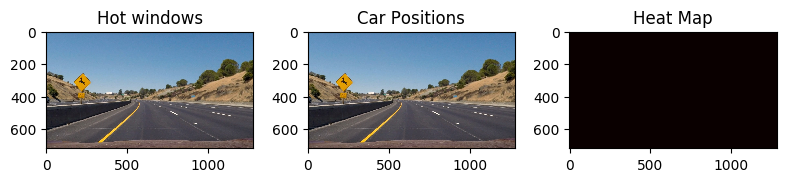

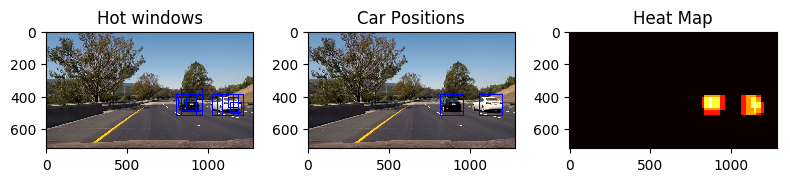

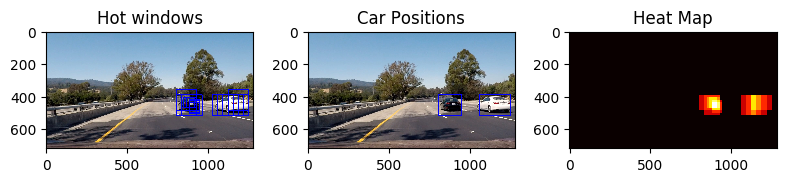

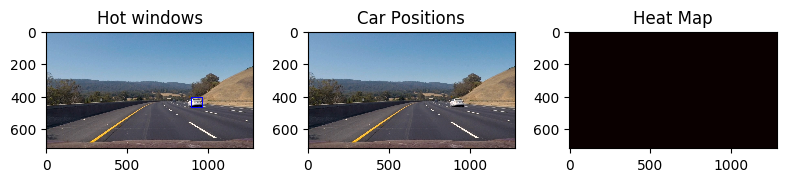

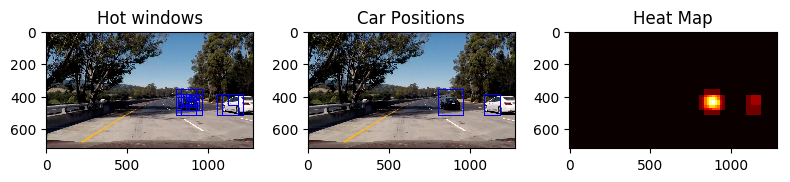

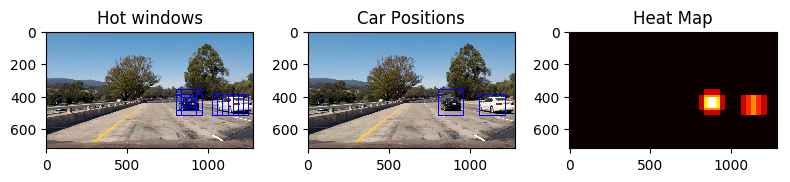

In [5]:
import collections
import argparse

# Globals
svc, X_scaler = None, None
buffer_hot_windows = collections.deque(maxlen=dict_config_params['buffer_len_hotwindows'])

if __name__ == '__main__':
        
    # Pickle dump classifier
    filename_classifier = "./classifiers_pickle.p"
    if (dict_config_params['use_cached_classifier'] is True and
            os.path.exists(filename_classifier)):
                print("\nUsing already available cached classifier.")
                svc, X_scaler = pickle.load( open(filename_classifier, "rb" ) )
    else:
        X, labels = get_training_data()    
        svc, X_scaler = fit_svm(X, labels, verbose=True)

    if dict_config_params['overwrite_cached_classifier']:
        print("\nOverwriting cached classifier.\n")
        pickle.dump([svc, X_scaler], open( filename_classifier, "wb" ) )

    main_test_images()
    #main_video(0.5)   # args.video_sec

In [6]:
### BKP

#parser = argparse.ArgumentParser()
#parser.add_argument("video_sec", help="No.of sec. of video to be processed.", type=int)
#args = parser.parse_args()
#print("\nWill process {} sec. of video\n".format(args.video_sec))

## Print config param dictionary
#print('\n=== Config param dictionary ===')
#for i in dict_config_params:
#    print ("{} = {}".format(i, dict_config_params[i]))
#print('\n')
